<a href="https://colab.research.google.com/github/Pramod858/Named-Entity-Recognition-Using-Transformers/blob/main/Named_Entity_Recognition_using_HuggingFace_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [65]:
!pip install transformers datasets evaluate
!pip install seqeval

# Imports

In [66]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import evaluate
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,DataCollatorForTokenClassification,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFRobertaForTokenClassification,TFAutoModelForTokenClassification,)

In [67]:
BATCH_SIZE=16
NUM_EPOCHS=2

# Data Preparation

 CONLL2003 is a widely used dataset for evaluating natural language processing (NLP) systems. It contains annotation on a wide range of NLP tasks, including named entity recognition, sentiment analysis, and parsing. The dataset is drawn from the Wall Street Journal and other newspapers, and it includes about 20,000 document paragraphs that have been manually annotated by human annotators. The data is split into several different sets, including training, validation, and test sets, and it is widely used in research and industry for developing NLP systems.  

In [68]:
dataset = load_dataset("conll2003")

In [69]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [70]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

 Roberta-base is a language modeling framework developed by Google. It uses a denoising autoencoder approach and is pre-trained on a large corpus of text. It is highly effective in a variety of natural language processing tasks, including text classification, named entity recognition, and question answering. In contrast to other models like BERT, Roberta-base only requires input sequencing from the user and is capable of generating coherent text in a few seconds. However, it is worth noting that its model size is significantly larger compared to other models in the domain.  

In [71]:
model_id="roberta-base"
tokenizer=RobertaTokenizerFast.from_pretrained(model_id,add_prefix_space=True)

In [72]:
inputs = tokenizer(dataset["train"][2]["tokens"], is_split_into_words=True,)
inputs.tokens()

['<s>', 'ĠBR', 'USS', 'ELS', 'Ġ1996', '-', '08', '-', '22', '</s>']

In [73]:
print(dataset['train'][2])

{'id': '2', 'tokens': ['BRUSSELS', '1996-08-22'], 'pos_tags': [22, 11], 'chunk_tags': [11, 12], 'ner_tags': [5, 0]}


In [74]:
print(inputs.word_ids())
print(dataset['train'][2]['ner_tags'])

[None, 0, 0, 0, 1, 1, 1, 1, 1, None]
[5, 0]


In [75]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [76]:
labels = dataset["train"][2]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[5, 0]
[-100, 5, 6, 6, 0, 0, 0, 0, 0, -100]


In [77]:
def tokenizer_function(dataset):
  out=tokenizer(dataset["tokens"],truncation=True,is_split_into_words=True,)
  out['labels']=align_labels_with_tokens(dataset["ner_tags"],out.word_ids())
  return out

In [78]:
tokenized_dataset=dataset.map(tokenizer_function,remove_columns=['id','tokens','pos_tags','chunk_tags','ner_tags',])

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [79]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [80]:
print(tokenized_dataset['train'][2])

{'input_ids': [0, 6823, 16551, 16416, 8008, 12, 3669, 12, 2036, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 5, 6, 6, 0, 0, 0, 0, 0, -100]}


A data collator is a function that takes a list of samples from a dataset and combines them into batches for efficient processing.

In [81]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors="tf"
)

In [82]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [83]:
tf_val_dataset = tokenized_dataset["validation"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

In [84]:
for i in tf_train_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(16, 53), dtype=int64, numpy=
array([[    0,  1426,   759,  2156,   391,  1101,    12,   805,  9528,
        12057,   603,     4,  2162,    10,  1647,  1968,    11, 13985,
         3432,   479,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1],
       [    0,  1444,  1770,     5,   315,   532,    15,   296,    11,
        10423, 12940,     8, 11279,   128,    29,  1288,    15,     5,
         2788,     9,    10,   203,    12, 10273, 12198,  9330, 11142,
         2156,    61,    24,    26,    74,  5042,     7,  5443,    11,
            5,   443,   479,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1],
       [    0,   480,  5480,  9022,    36,   369,   730,  4839,  2043,
            7,    68,   321

# Modeling

## Based on TFRobertaForSequenceClassification

TFRobertaForSequenceClassification" is a specific model architecture in the TensorFlow library that is designed for sequence classification tasks. It is based on the RoBERTa model, which is a variant of the BERT (Bidirectional Encoder Representations from Transformers) model.

In [85]:
model=TFRobertaForTokenClassification.from_pretrained(
    model_id,
    num_labels=9,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForTokenClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
model.summary()

Model: "tf_roberta_for_token_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 124061961 (473.26 MB)
Trainable params: 124061961 (473.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [87]:
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch*NUM_EPOCHS)

In [88]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps,)

In [89]:
model.compile(optimizer=optimizer,)
    #metrics=["accuracy"])

In [90]:
history=model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=NUM_EPOCHS,)

Epoch 1/2
878/878 [==============================] - 267s 226ms/step - loss: 0.1535 - val_loss: 0.0541
Epoch 2/2
878/878 [==============================] - 191s 218ms/step - loss: 0.0448 - val_loss: 0.0475


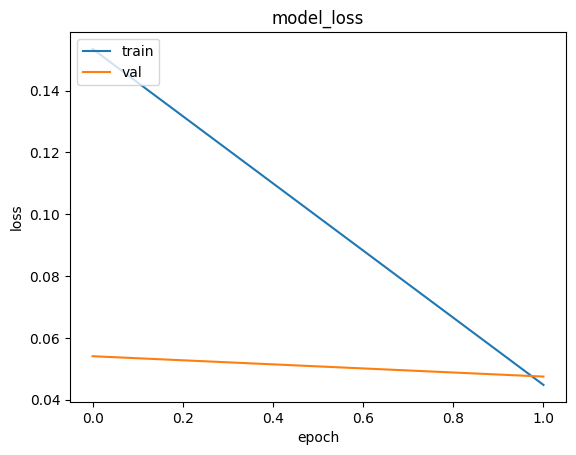

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

Seqeval is a Python library for sequence labeling evaluation.
It provides metrics such as precision, recall, and F1 score for sequence labeling tasks.
Seqeval supports various sequence labeling tasks such as named entity recognition, part-of-speech tagging, and semantic role labeling.

In [92]:
metric=evaluate.load("seqeval")

In [93]:
ind_to_label={0:'O', 1:'B-PER',2:'I-PER',3:'B-ORG',4:'I-ORG',5:'B-LOC',6:'I-LOC',7:'B-MISC',8:'I-MISC'}
all_predictions = []
all_labels = []

In [94]:
for batch in tf_val_dataset:
  logits = model.predict(batch)["logits"]
  labels = batch["labels"].numpy()
  predictions = tf.argmax(logits, axis=-1).numpy()
  #print(labels)
  #print(predictions)
  for prediction, label in zip(predictions, labels):
    for predicted_idx, label_idx in zip(prediction, label):
      if label_idx == -100:
          continue
      all_predictions.append(ind_to_label[predicted_idx])
      all_labels.append(ind_to_label[label_idx])

1/1 [==============================] - 0s 77ms/step


In [95]:
print(all_predictions)
print(all_labels)

['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 

In [96]:
metric.compute(predictions=[all_predictions], references=[all_labels])

{'LOC': {'precision': 0.9609207708779444,
  'recall': 0.9771366358192706,
  'f1': 0.9689608636977058,
  'number': 1837},
 'MISC': {'precision': 0.839918946301925,
  'recall': 0.8991323210412148,
  'f1': 0.8685175484546883,
  'number': 922},
 'ORG': {'precision': 0.9243445692883895,
  'recall': 0.9202087994034303,
  'f1': 0.922272047832586,
  'number': 1341},
 'PER': {'precision': 0.9715206878022569,
  'recall': 0.9815418023887079,
  'f1': 0.9765055360518499,
  'number': 1842},
 'overall_precision': 0.9363741530325566,
 'overall_recall': 0.9535509929316729,
 'overall_f1': 0.9448845159676478,
 'overall_accuracy': 0.9884323893099322}

# Testing


In [97]:
inputs=tokenizer(["You just got a call from UNESCO for a trip to India"], padding=True,return_tensors="tf")

In [98]:
print(inputs.tokens())
print(inputs.word_ids())
print(inputs['input_ids'])

['<s>', 'ĠYou', 'Ġjust', 'Ġgot', 'Ġa', 'Ġcall', 'Ġfrom', 'ĠUNESCO', 'Ġfor', 'Ġa', 'Ġtrip', 'Ġto', 'ĠIndia', '</s>']
[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, None]
tf.Tensor(
[[    0   370    95   300    10   486    31 26688    13    10  1805     7
    666     2]], shape=(1, 14), dtype=int32)


In [99]:
logits = model(**inputs).logits
print(logits.shape)
print(tf.argmax(logits,axis=-1))

(1, 14, 9)
tf.Tensor([[0 0 0 0 0 0 0 3 0 0 0 0 5 0]], shape=(1, 14), dtype=int64)


In [100]:
ind_to_label={0:'O', 1:'B-PER',2:'I-PER',3:'B-ORG',4:'I-ORG',5:'B-LOC',6:'I-LOC',7:'B-MISC',8:'I-MISC'}
out_str=""
current_index=0

In [101]:
for i in range(1,len(inputs.tokens())-1):
  if tf.argmax(logits,axis=-1)[0][i]!=0:
    out_str+=" "+str(inputs.tokens()[i])+"--->"+str(ind_to_label[tf.argmax(logits,axis=-1).numpy()[0][i]])
  else:
    out_str+=" "+str(inputs.tokens()[i])

In [102]:
print(out_str.replace("Ġ",""))

 You just got a call from UNESCO--->B-ORG for a trip to India--->B-LOC
